Feature Vector A: CNN-1 with 3×3 conv stack + max-pooling, then Flatten.
Feature Vector B: CNN-2 with 7/5/3/3 convs + average-pooling, then Flatten.
Merge: Concatenate A and B, remove duplicate/low-variance features, then PCA (optionally FA after PCA).
Classifier: Xception image branch fused with the reduced feature vector for final prediction.

In [1]:
# Dual-CNN Feature Extraction + PCA/FA + Xception Classifier
#  Configure paths, hyperparameters, and seeds (Colab/Local)

import os, sys, json, math, random
from dataclasses import dataclass
from typing import Tuple

import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

IN_COLAB = 'google.colab' in sys.modules

# --- Paths  ---
# Colab dataset layout:
# CSV: /content/drive/MyDrive/mini_proj_data/proj_metadata.csv
# Images: /content/drive/MyDrive/mini_proj_data/Processed_data/{image_id}.jpg
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/mini_proj_data'
    CSV_PATH = os.path.join(BASE_DIR, 'proj_metadata.csv')
    IMG_DIR = os.path.join(BASE_DIR, 'Processed_data')
    OUTPUT_DIR = os.path.join(BASE_DIR, 'dualcnn_outputs')
else:
    # Local defaults
    BASE_DIR = os.getcwd()
    CSV_PATH = os.path.join(BASE_DIR, 'proj_metadata.csv')
    IMG_DIR = os.path.join(BASE_DIR, 'Processed_data')
    OUTPUT_DIR = os.path.join(BASE_DIR, 'dualcnn_outputs')

# Control saving artifacts for repeated test runs
SAVE_ARTIFACTS = False
if SAVE_ARTIFACTS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- CSV schema expectations ---
# Columns: lesion_id, image_id, dx, dx_type, age, sex, localization, image_path
# - dx is the target label (string). We'll map to integers 0..C-1.
# - If image_path is empty, fallback to Processed_data/{image_id}.jpg under IMG_DIR

# --- Image / training hyperparams ---
IMG_SIZE: Tuple[int, int] = (224, 224)
BATCH_SIZE = 32
PREFETCH = 4

# --- Feature reduction params ---
USE_PCA = True
PCA_COMPONENTS = 128  # clipped to ≤ min(train_samples, feature_dim)
USE_FA = True
FA_COMPONENTS = 64    # optional FA after PCA

# --- Classifier params ---
INIT_LR = 3e-4
EPOCHS = 20
VAL_SPLIT = 0.1

print('Configured:')
print('CSV_PATH:', CSV_PATH)
print('IMG_DIR:', IMG_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('SAVE_ARTIFACTS:', SAVE_ARTIFACTS)
print('IMG_SIZE:', IMG_SIZE)

Mounted at /content/drive
Configured:
CSV_PATH: /content/drive/MyDrive/mini_proj_data/proj_metadata.csv
IMG_DIR: /content/drive/MyDrive/mini_proj_data/Processed_data
OUTPUT_DIR: /content/drive/MyDrive/mini_proj_data/dualcnn_outputs
SAVE_ARTIFACTS: False
IMG_SIZE: (224, 224)


In [2]:
# Config overrides and toggles (run after Step 1)
# use both CNN-1 and CNN-2 as feature extractors before PCA/FA
USE_CNN2 = True
print('USE_CNN2 =', USE_CNN2)

USE_CNN2 = True


In [3]:
# Step 2: Load metadata and prepare splits (uses dx as target)
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedGroupKFold

# Load CSV
meta = pd.read_csv(CSV_PATH)
print('Rows in CSV:', len(meta))

# Ensure required columns
required_cols = ['image_id', 'dx']
missing = [c for c in required_cols if c not in meta.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Columns present: {list(meta.columns)}")

# Resolve absolute image paths
# Prefer `image_path` when provided, else fallback to f"Processed_data/{image_id}.jpg"

def resolve_path(row):
    p = row.get('image_path', None)
    if isinstance(p, str) and len(p.strip()) > 0:
        p = p.strip()
        if os.path.isabs(p):
            return p
        return os.path.join(IMG_DIR, p)
    image_id = str(row['image_id']).strip()
    return os.path.join(IMG_DIR, f"{image_id}.jpg")

meta['abs_path'] = meta.apply(resolve_path, axis=1)

# Filter existing files only
exists = meta['abs_path'].apply(os.path.isfile)
missing_n = (~exists).sum()
if missing_n:
    print(f"Warning: {missing_n} images not found; dropping those rows")
meta = meta[exists].reset_index(drop=True)

# Encode labels from dx (strings) → integers
labels_str = meta['dx'].astype(str)
classes = sorted(labels_str.unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
meta['label_id'] = labels_str.map(class_to_idx).astype(int)
num_classes = len(classes)
print('Classes:', classes)
print('Num classes:', num_classes)

# Optional group-aware split via lesion_id if available
use_groups = 'lesion_id' in meta.columns and meta['lesion_id'].notna().any()

# 80/10/10 stratified split (group-aware if possible)
if use_groups:
    groups = meta['lesion_id'].astype(str).values
    y = meta['label_id'].values
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
    tr_idx, tmp_idx = next(sgkf.split(meta, y, groups))
    train_df = meta.iloc[tr_idx].reset_index(drop=True)
    temp_df  = meta.iloc[tmp_idx].reset_index(drop=True)
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['label_id'].values, random_state=SEED
    )
else:
    train_df, temp_df = train_test_split(
        meta, test_size=0.2, stratify=meta['label_id'].values, random_state=SEED
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['label_id'].values, random_state=SEED
    )

print('Train/Val/Test sizes:', len(train_df), len(val_df), len(test_df))

# Optionally save label maps and splits
if SAVE_ARTIFACTS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    with open(os.path.join(OUTPUT_DIR, 'label_map.json'), 'w') as f:
        json.dump({'class_to_idx': class_to_idx, 'idx_to_class': idx_to_class}, f, indent=2)
    for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
        df[['abs_path', 'label_id']].to_csv(os.path.join(OUTPUT_DIR, f'{name}_split.csv'), index=False)
        print(f'Saved {name} split CSV with {len(df)} rows')

Rows in CSV: 10015
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Num classes: 7
Train/Val/Test sizes: 8001 1007 1007


In [4]:
# Step 3: Build tf.data pipelines for raw images
import tensorflow as tf

def decode_resize(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    return img

@tf.function
def normalize_01(img):
    return img

@tf.function
def normalize_for_xception(img):
    # Xception expects [-1, 1]
    return img * 2.0 - 1.0

def make_image_ds(paths, labels=None, batch=BATCH_SIZE, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if shuffle:
        ds = ds.shuffle(len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_resize, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(normalize_01, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(PREFETCH)
    if labels is not None:
        lab = tf.convert_to_tensor(labels, dtype=tf.int32)
        lds = tf.data.Dataset.from_tensor_slices(lab).batch(batch)
        ds = tf.data.Dataset.zip((ds, lds))
    return ds

train_paths = train_df['abs_path'].tolist()
val_paths = val_df['abs_path'].tolist()
test_paths = test_df['abs_path'].tolist()

train_labels = train_df['label_id'].astype(int).values
val_labels = val_df['label_id'].astype(int).values
test_labels = test_df['label_id'].astype(int).values

train_img_ds = make_image_ds(train_paths, train_labels, shuffle=True)
val_img_ds = make_image_ds(val_paths, val_labels, shuffle=False)
test_img_ds = make_image_ds(test_paths, test_labels, shuffle=False)

print('Pipelines ready.')

Pipelines ready.


In [6]:
# Step 4: Define CNN-1 and CNN-2 (feature extractors)
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Input, Dropout,GlobalAveragePooling2D

l2r = regularizers.l2(1e-4)

def build_cnn1(input_shape):
    x_in = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2r)(x_in)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2r)(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2r)(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2r)(x)
    x = MaxPooling2D((2,2))(x)

    x = GlobalAveragePooling2D()(x)  # was Flatten()
    return Model(x_in, x, name='CNN1')

def build_cnn2(input_shape):
    x_in = Input(shape=input_shape)
    x = Conv2D(256, (7,7), activation='relu', padding='same', kernel_regularizer=l2r)(x_in)
    x = AveragePooling2D((2,2))(x)

    x = Conv2D(128, (5,5), activation='relu', padding='same', kernel_regularizer=l2r)(x)
    x = AveragePooling2D((2,2))(x)

    x = Conv2D(96, (3,3), activation='relu', padding='same', kernel_regularizer=l2r)(x)
    x = AveragePooling2D((2,2))(x)

    x = Conv2D(96, (3,3), activation='relu', padding='same', kernel_regularizer=l2r)(x)
    x = AveragePooling2D((2,2))(x)

    x = GlobalAveragePooling2D()(x)  # was Flatten()
    return Model(x_in, x, name='CNN2')

cnn_input_shape = (*IMG_SIZE, 3)
CNN1 = build_cnn1(cnn_input_shape)
CNN2 = build_cnn2(cnn_input_shape)


In [10]:
def extract_features(model: tf.keras.Model, ds: tf.data.Dataset, batch_size=32) -> np.ndarray:
    # Ensure dataset is batched and prefetched
    if not hasattr(ds, "_variant_tensor_attr"):  # check if already batched
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Directly run prediction on the dataset
    features = model.predict(ds, verbose=1)
    return features


In [11]:
# Build flat image datasets (without labels) to reuse for all feature extractors
train_imgs_only = make_image_ds(train_paths, labels=None, shuffle=False)
val_imgs_only = make_image_ds(val_paths, labels=None, shuffle=False)
test_imgs_only = make_image_ds(test_paths, labels=None, shuffle=False)

# Extract
features_cnn1_train = extract_features(CNN1, train_imgs_only)
features_cnn1_val   = extract_features(CNN1, val_imgs_only)
features_cnn1_test  = extract_features(CNN1, test_imgs_only)

if USE_CNN2:
    features_cnn2_train = extract_features(CNN2, train_imgs_only)
    features_cnn2_val   = extract_features(CNN2, val_imgs_only)
    features_cnn2_test  = extract_features(CNN2, test_imgs_only)
    # Concatenate A ⊕ B
    concat_train = np.concatenate([features_cnn1_train, features_cnn2_train], axis=1)
    concat_val   = np.concatenate([features_cnn1_val,   features_cnn2_val],   axis=1)
    concat_test  = np.concatenate([features_cnn1_test,  features_cnn2_test],  axis=1)
else:
    # Dual-1 only
    concat_train = features_cnn1_train
    concat_val   = features_cnn1_val
    concat_test  = features_cnn1_test

# Remove exact-duplicate columns or near-zero variance
# 1) Variance threshold to drop near-constant features
vt = VarianceThreshold(threshold=1e-8)
concat_train_v = vt.fit_transform(concat_train)
concat_val_v   = vt.transform(concat_val)
concat_test_v  = vt.transform(concat_test)

# 2) Remove duplicate columns by hashing values (train-driven)
rounded = np.round(concat_train_v, 6)
col_sigs = { }
keep_indices = []
for j in range(rounded.shape[1]):
    sig = hash(rounded[:, j].tobytes())
    if sig not in col_sigs:
        col_sigs[sig] = j
        keep_indices.append(j)

concat_train_vu = concat_train_v[:, keep_indices]
concat_val_vu   = concat_val_v[:, keep_indices]
concat_test_vu  = concat_test_v[:, keep_indices]

251/251 ━━━━━━━━━━━━━━━━━━━━ 998s 4s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 318s 10s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 320s 10s/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 258ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 489ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step


In [12]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.feature_selection import VarianceThreshold


# PCA on concatenated features
if USE_PCA:
    pca_dim = min(PCA_COMPONENTS, concat_train_vu.shape[0], concat_train_vu.shape[1])
    pca = PCA(n_components=pca_dim, random_state=SEED)
    pca_train = pca.fit_transform(concat_train_vu)
    pca_val   = pca.transform(concat_val_vu)
    pca_test  = pca.transform(concat_test_vu)
else:
    pca = None
    pca_train, pca_val, pca_test = concat_train_vu, concat_val_vu, concat_test_vu

# Optional FA after PCA
if USE_FA:
    fa_dim = min(FA_COMPONENTS, pca_train.shape[1] - 1) if pca_train.shape[1] > 1 else 1
    fa = FactorAnalysis(n_components=fa_dim, random_state=SEED)
    feat_train = fa.fit_transform(pca_train)
    feat_val   = fa.transform(pca_val)
    feat_test  = fa.transform(pca_test)
else:
    fa = None
    feat_train, feat_val, feat_test = pca_train, pca_val, pca_test

print('Final feature shapes (train/val/test):', feat_train.shape, feat_val.shape, feat_test.shape)

# Optionally persist reducers and indices for reproducibility
if SAVE_ARTIFACTS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    artifacts = {
        'variance_threshold_threshold': 1e-8,
        'vt_support_indices': np.where(vt.get_support())[0].tolist(),
        'duplicate_keep_indices': keep_indices,
        'use_pca': USE_PCA,
        'pca_components': int(feat_train.shape[1]) if USE_PCA else None,
        'use_fa': USE_FA,
        'fa_components': int(fa.n_components) if USE_FA else None,
        'use_cnn2': bool(USE_CNN2),
    }
    with open(os.path.join(OUTPUT_DIR, 'reducers_meta.json'), 'w') as f:
        json.dump(artifacts, f, indent=2)
    if pca is not None:
        import pickle
        with open(os.path.join(OUTPUT_DIR, 'pca.pkl'), 'wb') as f:
            pickle.dump(pca, f)
    if USE_FA and fa is not None:
        import pickle
        with open(os.path.join(OUTPUT_DIR, 'fa.pkl'), 'wb') as f:
            pickle.dump(fa, f)

Final feature shapes (train/val/test): (8001, 64) (1007, 64) (1007, 64)


In [15]:
# Step 6: Xception classifier over image + reduced features (late fusion)
from tensorflow.keras import layers, models
from tensorflow.keras.applications import xception

# Image branch (Xception, frozen)
img_in = layers.Input(shape=(*IMG_SIZE, 3), name='img_in')
# use Keras' built-in preprocessing as a Lambda, not a tf.function
pre_img = layers.Lambda(xception.preprocess_input, name='xception_preprocess')(img_in)
base = xception.Xception(include_top=False, weights='imagenet', input_tensor=pre_img, pooling=None)
for layer in base.layers:
    layer.trainable = False
x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.3)(x)

# Feature vector branch
feat_in = layers.Input(shape=(feat_train.shape[1],), name='feat_in')
f = layers.Dense(256, activation='relu')(feat_in)
f = layers.Dropout(0.3)(f)

# Concatenate
h = layers.Concatenate()([x, f])
h = layers.Dense(256, activation='relu')(h)
h = layers.Dropout(0.3)(h)
out = layers.Dense(num_classes, activation='softmax', dtype='float32')(h)

clf = models.Model([img_in, feat_in], out)
clf.compile(optimizer=tf.keras.optimizers.Adam(INIT_LR),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
clf.summary()

# Build fusion datasets matching pairs: (image, features) -> label
# Prepare feature tensors aligned with order of paths
path_to_index = {p: i for i, p in enumerate(train_paths + val_paths + test_paths)}

# Build aligned features per split
train_idx = [path_to_index[p] for p in train_paths]
val_idx   = [path_to_index[p] for p in val_paths]
test_idx  = [path_to_index[p] for p in test_paths]

# Since feat_* were built in the same order as train/val/test datasets, align directly
feat_train_tf = tf.convert_to_tensor(feat_train, dtype=tf.float32)
feat_val_tf   = tf.convert_to_tensor(feat_val, dtype=tf.float32)
feat_test_tf  = tf.convert_to_tensor(feat_test, dtype=tf.float32)

# Helper to build fusion dataset
def make_fusion_ds(paths, labels, feats):
    img_ds = tf.data.Dataset.from_tensor_slices(paths)
    # decode/resize only; model does Xception preprocessing
    img_ds = img_ds.map(lambda p: decode_resize(p), num_parallel_calls=tf.data.AUTOTUNE)
    feat_ds = tf.data.Dataset.from_tensor_slices(feats)
    lab_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int32))
    ds = tf.data.Dataset.zip(((img_ds, feat_ds), lab_ds))
    ds = ds.batch(BATCH_SIZE).prefetch(PREFETCH)
    return ds

train_fused = make_fusion_ds(train_paths, train_labels, feat_train_tf)
val_fused   = make_fusion_ds(val_paths,   val_labels,   feat_val_tf)
test_fused  = make_fusion_ds(test_paths,  test_labels,  feat_test_tf)

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
cbs = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

hist = clf.fit(train_fused, validation_data=val_fused, epochs=EPOCHS, callbacks=cbs, verbose=1)

print('Evaluating on test...')
clf.evaluate(test_fused, verbose=1)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_in (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception_preprocess │ (None, 224, 224,  │          0 │ img_in[0][0]      │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ xception_preproc… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0

 Total params: 21,469,999 (81.90 MB)

 Trainable params: 608,519 (2.32 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 420ms/step - accuracy: 0.5527 - loss: 1.5811 - val_accuracy: 0.6773 - val_loss: 1.8515 - learning_rate: 3.0000e-04
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 75s 299ms/step - accuracy: 0.3011 - loss: 2.2581 - val_accuracy: 0.6773 - val_loss: 1.5107 - learning_rate: 3.0000e-04
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 73s 291ms/step - accuracy: 0.3126 - loss: 2.0294 - val_accuracy: 0.6773 - val_loss: 1.4118 - learning_rate: 3.0000e-04
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 88s 314ms/step - accuracy: 0.3392 - loss: 1.9469 - val_accuracy: 0.6773 - val_loss: 1.4495 - learning_rate: 3.0000e-04
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 71s 282ms/step - accuracy: 0.2928 - loss: 1.9732 - val_accuracy: 0.6773 - val_loss: 1.5043 - learning_rate: 3.0000e-04
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.3296 - loss: 2.0661 - val_accuracy: 0.6773 - val_loss: 1.4544 - learning_rate: 3.0000e-04
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 3

[1.8567938804626465, 0.6762661337852478]

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.6553 - loss: 1.9830
Test -> loss: 1.8568 acc: 0.6763

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        34
           1     0.0000    0.0000    0.0000        50
           2     0.0000    0.0000    0.0000       103
           3     0.0000    0.0000    0.0000        11
           4     0.0000    0.0000    0.0000       111
           5     0.6763    1.0000    0.8069       681
           6     0.0000    0.0000    0.0000        17

    accuracy                         0.6763      1007
   macro avg     0.0966    0.1429    0.1153      1007
weighted avg     0.4573    0.6763    0.5457      1007



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


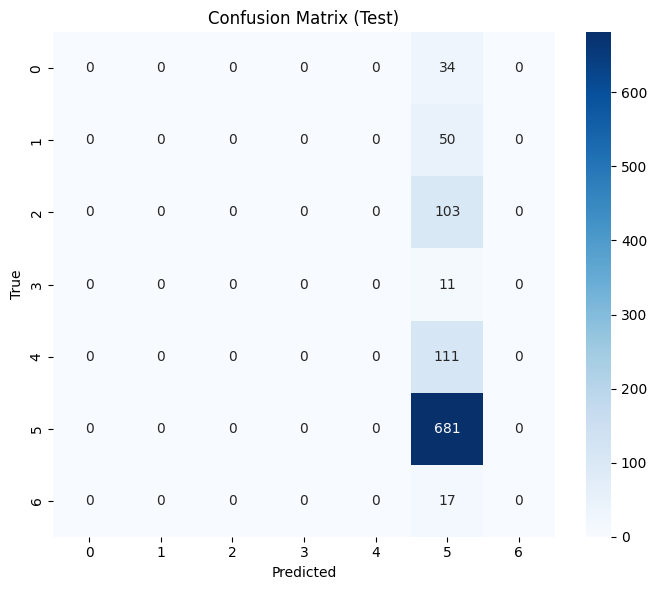

In [16]:
# Evaluate, report ( SAVE_ARTIFACTS=False)
import time, pickle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate
test_loss, test_acc = clf.evaluate(test_fused, verbose=1)
print(f'Test -> loss: {test_loss:.4f} acc: {test_acc:.4f}')

# Predictions for detailed report
all_true, all_pred = [], []
for (imgs, feats), y in test_fused:
    p = clf.predict([imgs, feats], verbose=0)
    all_pred.append(np.argmax(p, axis=1))
    all_true.append(y.numpy())

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_pred)

print('\nClassification report:')
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Save artifacts if enabled
if SAVE_ARTIFACTS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    stamp = time.strftime('%Y%m%d-%H%M%S')
    model_path = os.path.join(OUTPUT_DIR, f'xception_dualcnn_{IMG_SIZE[0]}_{stamp}.keras')
    clf.save(model_path)
    print('Saved model to:', model_path)

    run_meta = {
        'seed': SEED,
        'img_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'num_classes': int(num_classes),
        'use_pca': USE_PCA,
        'pca_components': int(pca.n_components_) if USE_PCA else None,
        'use_fa': USE_FA,
        'fa_components': int(fa.n_components) if USE_FA else None,
        'test_loss': float(test_loss),
        'test_acc': float(test_acc),
    }
    with open(os.path.join(OUTPUT_DIR, f'run_meta_{stamp}.json'), 'w') as f:
        json.dump(run_meta, f, indent=2)

    np.save(os.path.join(OUTPUT_DIR, f'y_train_{stamp}.npy'), train_labels)
    np.save(os.path.join(OUTPUT_DIR, f'y_val_{stamp}.npy'),   val_labels)
    np.save(os.path.join(OUTPUT_DIR, f'y_test_{stamp}.npy'),  test_labels)

    print('Artifacts saved in:', OUTPUT_DIR)